# Simulation of Bock (1986) experiment

### Set-up

In [51]:
import random
import numpy as np
from copy import deepcopy
from importlib import reload 

import syntactic_wm as cjn ## Our model
reload(cjn)


################
## Parameters ##
################
num_steps = 10 # number of time steps taken by each word input.
head = 1 # number of time steps buffering the front of each sentence.
tail = 20 # number of time steps buffering the end of each sentence.
no_periods = 1 # number of epochs each sentence is presented to the model.

lambda_cc = 20 # learning rate of short-term synaptic plasticity amongst role neurons.
lambda_cf = 1 # learning rate of short-term synaptic plasticity between role and word neurons.

tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

beta = 1.3 # decay factor of firing rates.

n_word_neurons = 15 # number of word neurons initialised (f)
n_role_neurons = 10 # number of role neurons initialised (c)

gamma = 0.5 # factor dampening connectivity amongst role neurons.

epsilon_cc = 12 #9 # the ceiling of c-c connections when without long-term encoding, while taking into account of negative bias k. 
k_cc = 10 # negative bias, i.e. negative k_cc is the floor of c-c connections.

epsilon_cf = 4 # the ceiling of c-f connections when without long-term encoding, while taking into account of negative bias k. 
k_cf = 1 # negative bias, i.e. negative k_cf is the floor of c-f connections.

h = 6 #2 # normalising factor for inhibition between c-f connections.

W_mc = 4 # connectivity between morph and role neurons (non-encodable)
W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

W_ff = -2  # connectivity amongst word neurons (non-encodable)

unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

k_L_cc = 11 # long-term encoding amongst role neurons 
k_L_cf = 2 # long-term encoding between role and word neurons

# also note that seed will not have an effect on recall unless noise is added to the network.
seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

We will next define the priming sentences, both in active and passive voices. <br>
We will also define the 'target picture' which is a bag of words all encoded to the network simultaneously.

In [52]:
# long-term encodings
# A fan punched the referee (Active) ## 0-1-2-3-4-5-8
# vs
# The referee was punched by the fan (Passive) ## 0-4-5-6-3-7-1-2-8
LT_wc_knowledge = [[0,0], # start
                   [1,1], # a
                   [2,2], # fan -- subject
                   [3,3], # punched
                   [4,4], # the
                   [5,5], # referee -- object
                   [2,5], # fan being object
                   [5,2], # referee being object
                   [6,6], # was being another verb
                   [7,7], # by (preposition)
                   [8,8], # end
                   [9,2],# other1 subjects
                   [10,2], # other2 subjects
                   [9,5], # other1 objects
                   [10,5], # other2 objects
                   [11,3] # other3 verbs
                  ] 
LT_cc_knowledge = [[0,1,2,3,4,5,8],[0,4,5,6,3,7,1,2,8]]

morph_nodes = [2,5] # 2 is morpheme for subject and 5 is morpheme for object

### Priming - active voice sentence
sentence_prime_act = [] #0-1-9-11-4-10-8
for n in range(head): sentence_prime_act.append(cjn.in_in())
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=0))
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=1))
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=9,morpheme=2)) #subject
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=11)) # verb
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=4))
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=10,morpheme=5)) #object
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=8))
for n in range(tail): sentence_prime_act.append(cjn.in_in())

### Priming - passive voice sentence
sentence_prime_pass = [] # 0-4-10-6-11-7-1-9-8
for n in range(head): sentence_prime_pass.append(cjn.in_in())
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=0))
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=4))
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=10,morpheme=5)) #object
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=6))
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=11)) #verb
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=7))
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=1))
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=9,morpheme=2)) #subject
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=8))
for n in range(tail): sentence_prime_pass.append(cjn.in_in())


In [53]:
# priming sentence can be either active or passive voice
# for this example, we will be using the passive voice sentence
sentence = sentence_prime_act

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       morph_nodes = morph_nodes
                      )


# running the encoding phase - encoding the priming sentence
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  91
********************


The next phase is the morpheme binding phase, where semantic items in the 'target picture' are bind to appropriate role neurons with the help of morpheme neurons.

In [54]:
no_periods = 8 # binding over 5 epochs

# input for binding
pre_sentence_1 = []
for n in range(20): pre_sentence_1.append(cjn.in_in())
for n in range(3): pre_sentence_1.append(cjn.in_in(word=2,morpheme=2))
for n in range(20): pre_sentence_1.append(cjn.in_in())
for n in range(3): pre_sentence_1.append(cjn.in_in(word=3))
for n in range(20): pre_sentence_1.append(cjn.in_in())
for n in range(3): pre_sentence_1.append(cjn.in_in(word=5,morpheme=5))
for n in range(20): pre_sentence_1.append(cjn.in_in())
    
# during this phase, the learning rate within roles layer is switched to zero.
for n in range(n_role_neurons): # parent index
    for i in range(n_role_neurons): # child index
        WM_ori.cc_conn_dict[str(n)+str(i)].LR = 0 # switching off encoding between role neurons
    
sentence = pre_sentence_1
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori,time_steps=len(sentence)*no_periods,sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  89
********************
Epoch = 2
Number of recorded time steps:  178
********************
Epoch = 3
Number of recorded time steps:  267
********************
Epoch = 4
Number of recorded time steps:  356
********************
Epoch = 5
Number of recorded time steps:  445
********************
Epoch = 6
Number of recorded time steps:  534
********************
Epoch = 7
Number of recorded time steps:  623
********************
Epoch = 8
Number of recorded time steps:  712
********************


Let's visualise the encoding resulting from morpheme binding phase.

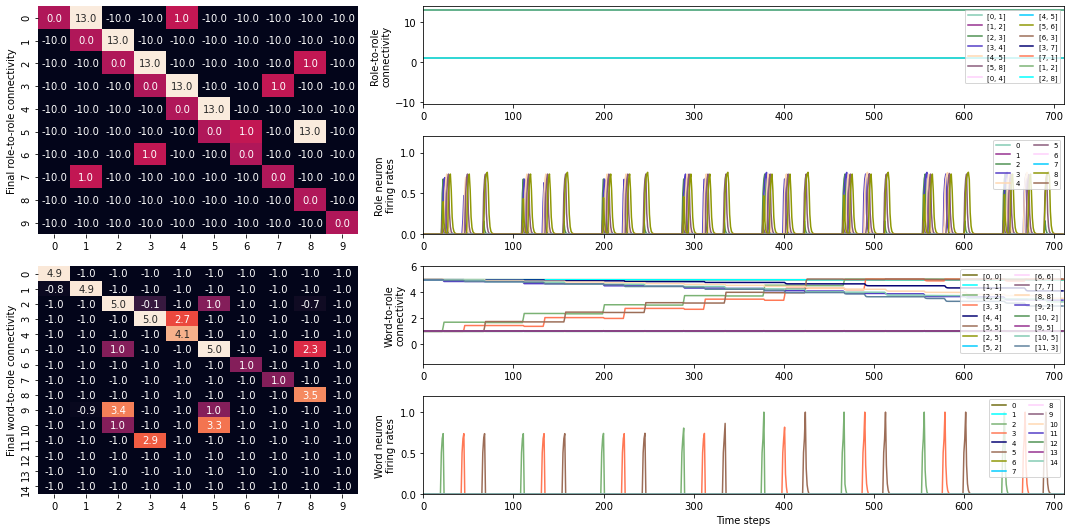

In [55]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx,no_periods=no_periods)

The next step is to present the network with the bag words from the 'target picture'. <br>
Some of the parameters are adjusted to allow serialisation.

In [56]:
WM = deepcopy(WM_ori) # copy the network first
# Note role neurons encoding remain switched off.

no_periods = 1 # encoding 'target picture' over 1 epoch
num_steps = 20

auto_gramm = True # turning on serialisation
WM.auto_gramm = auto_gramm
for n in range(n_role_neurons):
    WM.role_neuron_dict[str(n)].auto_gramm = auto_gramm
for n in range(n_word_neurons):
    WM.word_neuron_dict[str(n)].auto_gramm = auto_gramm
for n in morph_nodes:
    WM.morph_dict[str(n)].auto_gramm = auto_gramm

### Target picture
sentence_target = []
for n in range(head): sentence_target.append(cjn.in_in())
for n in range(2): sentence_target.append(cjn.in_in(word=0))
for n in range(num_steps): sentence_target.append([cjn.in_in(word=1),cjn.in_in(word=2,morpheme=2),cjn.in_in(word=3),cjn.in_in(word=4),cjn.in_in(word=5,morpheme=5),cjn.in_in(word=6),cjn.in_in(word=7)])
for n in range(2): sentence_target.append(cjn.in_in(word=8))
for n in range(tail): sentence_target.append(cjn.in_in())
    
sentence = sentence_target # bag of words
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM,time_steps=len(sentence)*no_periods,sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  45
********************


Let's visualise the encoding resulting from "Target Picture" phase.

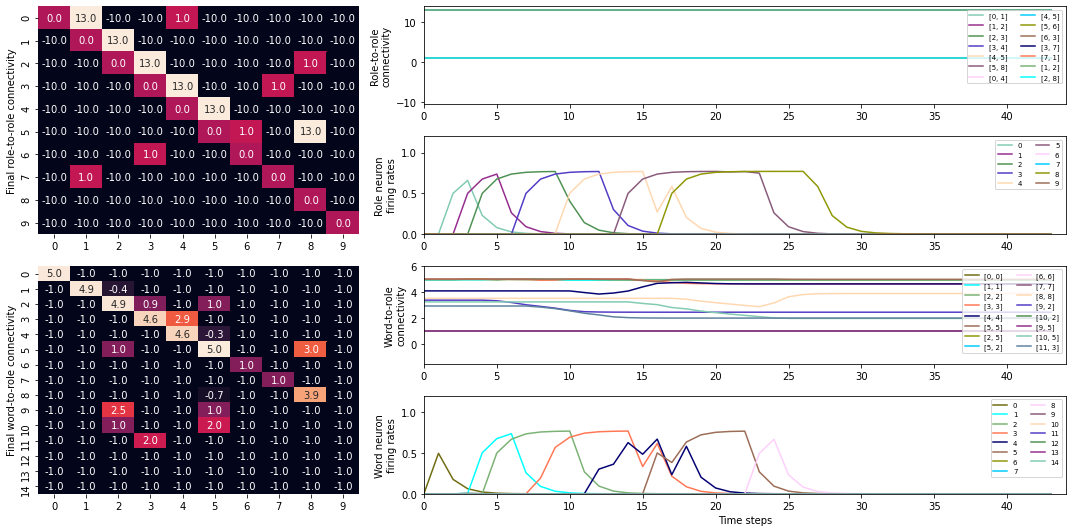

In [57]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx,no_periods=no_periods)

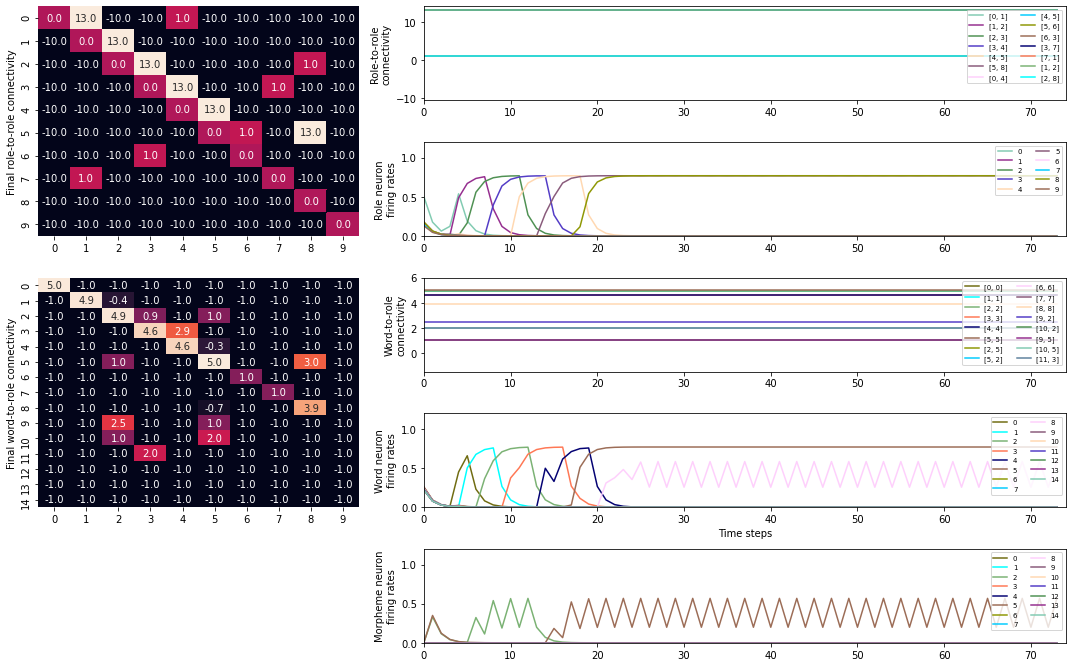

The final recall output is: 
[[0.0], [1.0], [2.0], [3.0], [4.0], [5.0]]


In [58]:
WM_r = deepcopy(WM) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r, morph_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

For comparing data with Bock (1986) experiment, we repeated the above experiment 1000 times with the following noise and learning rate changes.

In [7]:
lambda_cc = 15 # note this is to be changed only for priming phase. lambda_cc remains to be zero during morphene binding and 'target picture' phases.
unified_noise = 1 # noise level if noise is present
cc_noise = True 
wc_noise = True